In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from loguru import logger
from pathlib import Path
from scipy import signal

In [2]:
class EEG:
    def __init__(self, data_dir: Path, intencities: list[float], n_channels: int):
        self.data_dir = data_dir
        self.intencities = intencities
        self.n_channels = n_channels

    def load_participant(self, participant_id: int):
        self.int = {}
        self.delta = {}
        self.theta = {}
        self.alpha = {}
        self.beta = {}
        self.gamma = {}

        for i in self.intencities:
            self.int[i] = np.loadtxt(self.data_dir / f"Participant {participant_id}" / "Figs for spectra" / f"Backgr_int_{i}.dat")
            delta_signal = np.empty(self.int[i].shape)
            theta_signal =  np.empty(self.int[i].shape)
            alpha_signal = np.empty(self.int[i].shape)
            beta_signal = np.empty(self.int[i].shape)
            gamma_signal = np.empty(self.int[i].shape)
            for c in range(self.int[i].shape[1]):
                delta_signal[:, c], theta_signal[:, c], alpha_signal[:, c], beta_signal[:, c], gamma_signal[:, c] = self._fir_filtering(i, c)

            self.delta[i] = delta_signal
            self.theta[i] = theta_signal
            self.alpha[i] = alpha_signal
            self.beta[i] = beta_signal 
            self.gamma[i] = gamma_signal

        participant_info = {}
        participant_info["delta"] = self.delta
        participant_info["theta"] = self.theta
        participant_info["alpha"] = self.alpha
        participant_info["beta"] = self.beta
        participant_info["gamma"] = self.gamma

        return participant_info

    def _fir_filtering(self, i, c):
        filter_delta = signal.firwin(400, [1.0, 4.0], pass_zero=False, fs=250)
        filter_theta = signal.firwin(400, [5.0, 8.0], pass_zero=False, fs=250)
        filter_alpha = signal.firwin(400, [8.0, 12.0], pass_zero=False, fs=250)
        filter_beta = signal.firwin(400, [13.0, 30.0], pass_zero=False, fs=250)
        filter_gamma = signal.firwin(400, [31.0, 45.0], pass_zero=False, fs=250)

        res_delta = signal.convolve(self.int[i][:, c], filter_delta, mode='same')
        res_theta = signal.convolve(self.int[i][:, c], filter_theta, mode='same')
        res_alpha = signal.convolve(self.int[i][:, c], filter_alpha, mode='same')
        res_beta = signal.convolve(self.int[i][:, c], filter_beta, mode='same')
        res_gamma = signal.convolve(self.int[i][:, c], filter_gamma, mode='same')

        return res_delta, res_theta, res_alpha, res_beta, res_gamma

def process_signal_type_participant(dataset: EEG, user: int, signal_type: str):
    eeg_person = dataset.load_participant(user)

    person_signals = []
    signal_index = []
    for i in dataset.intencities:
        for ch in range(dataset.n_channels):
            signal_series = eeg_person[signal_type].get(i)[:, ch][:15000]
            person_signals.append(signal_series)

            signal_index.append([user, i, ch])            

    person_signal_index_df = pd.DataFrame(signal_index, columns=["user", "intensity", "channel"])
    person_signal_index_df["is_left_channel"] = np.where(person_signal_index_df["channel"] % 2 == 0, 1, 0)

    person_signals_df = pd.DataFrame(person_signals)

    return pd.concat([person_signal_index_df, person_signals_df], axis=1)

In [3]:
data_dir = Path("./dataset")
intencities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
n_channels = 31

dataset = EEG(data_dir=data_dir, intencities=intencities, n_channels=n_channels)

In [4]:
data = []

for user in [1, 2, 3, 4, 5]:
    for signal_type in ["delta", "theta", "alpha", "beta", "gamma"]:
        data.append(process_signal_type_participant(dataset, user, signal_type))

data = pd.concat(data, axis=0).reset_index(drop=True)

data.head()

,user,intensity,channel,is_left_channel,0,1,2,3,4,5,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
0,1,0.1,0,1,32.819580,22.394499,11.944530,1.509794,-8.869929,-19.140559,...,5.761321,8.584314,11.482307,14.444269,17.451520,20.490840,23.550929,26.612040,29.656919,32.678659
1,1,0.1,1,0,22.895093,22.571077,22.213273,21.817371,21.388242,20.932859,...,-36.569596,-37.383749,-38.258960,-39.193345,-40.186622,-41.226317,-42.301337,-43.410787,-44.548579,-45.696425
2,1,0.1,2,1,22.636168,25.515590,28.336306,31.081621,33.736376,36.288001,...,-57.224056,-57.872630,-58.465101,-58.998834,-59.471828,-59.881532,-60.224889,-60.496918,-60.690027,-60.795766
3,1,0.1,3,0,36.106648,38.336931,40.448344,42.426091,44.260684,45.944858,...,-9.807186,-7.906850,-5.966429,-3.996789,-2.011164,-0.023158,1.954782,3.909010,5.827176,7.701683
4,1,0.1,4,1,26.015135,23.859016,21.597520,19.234030,16.773968,14.223820,...,-20.737286,-19.244307,-17.681272,-16.058450,-14.386304,-12.677365,-10.941320,-9.185652,-7.417999,-5.644647


In [5]:
data.shape

(7750, 15004)

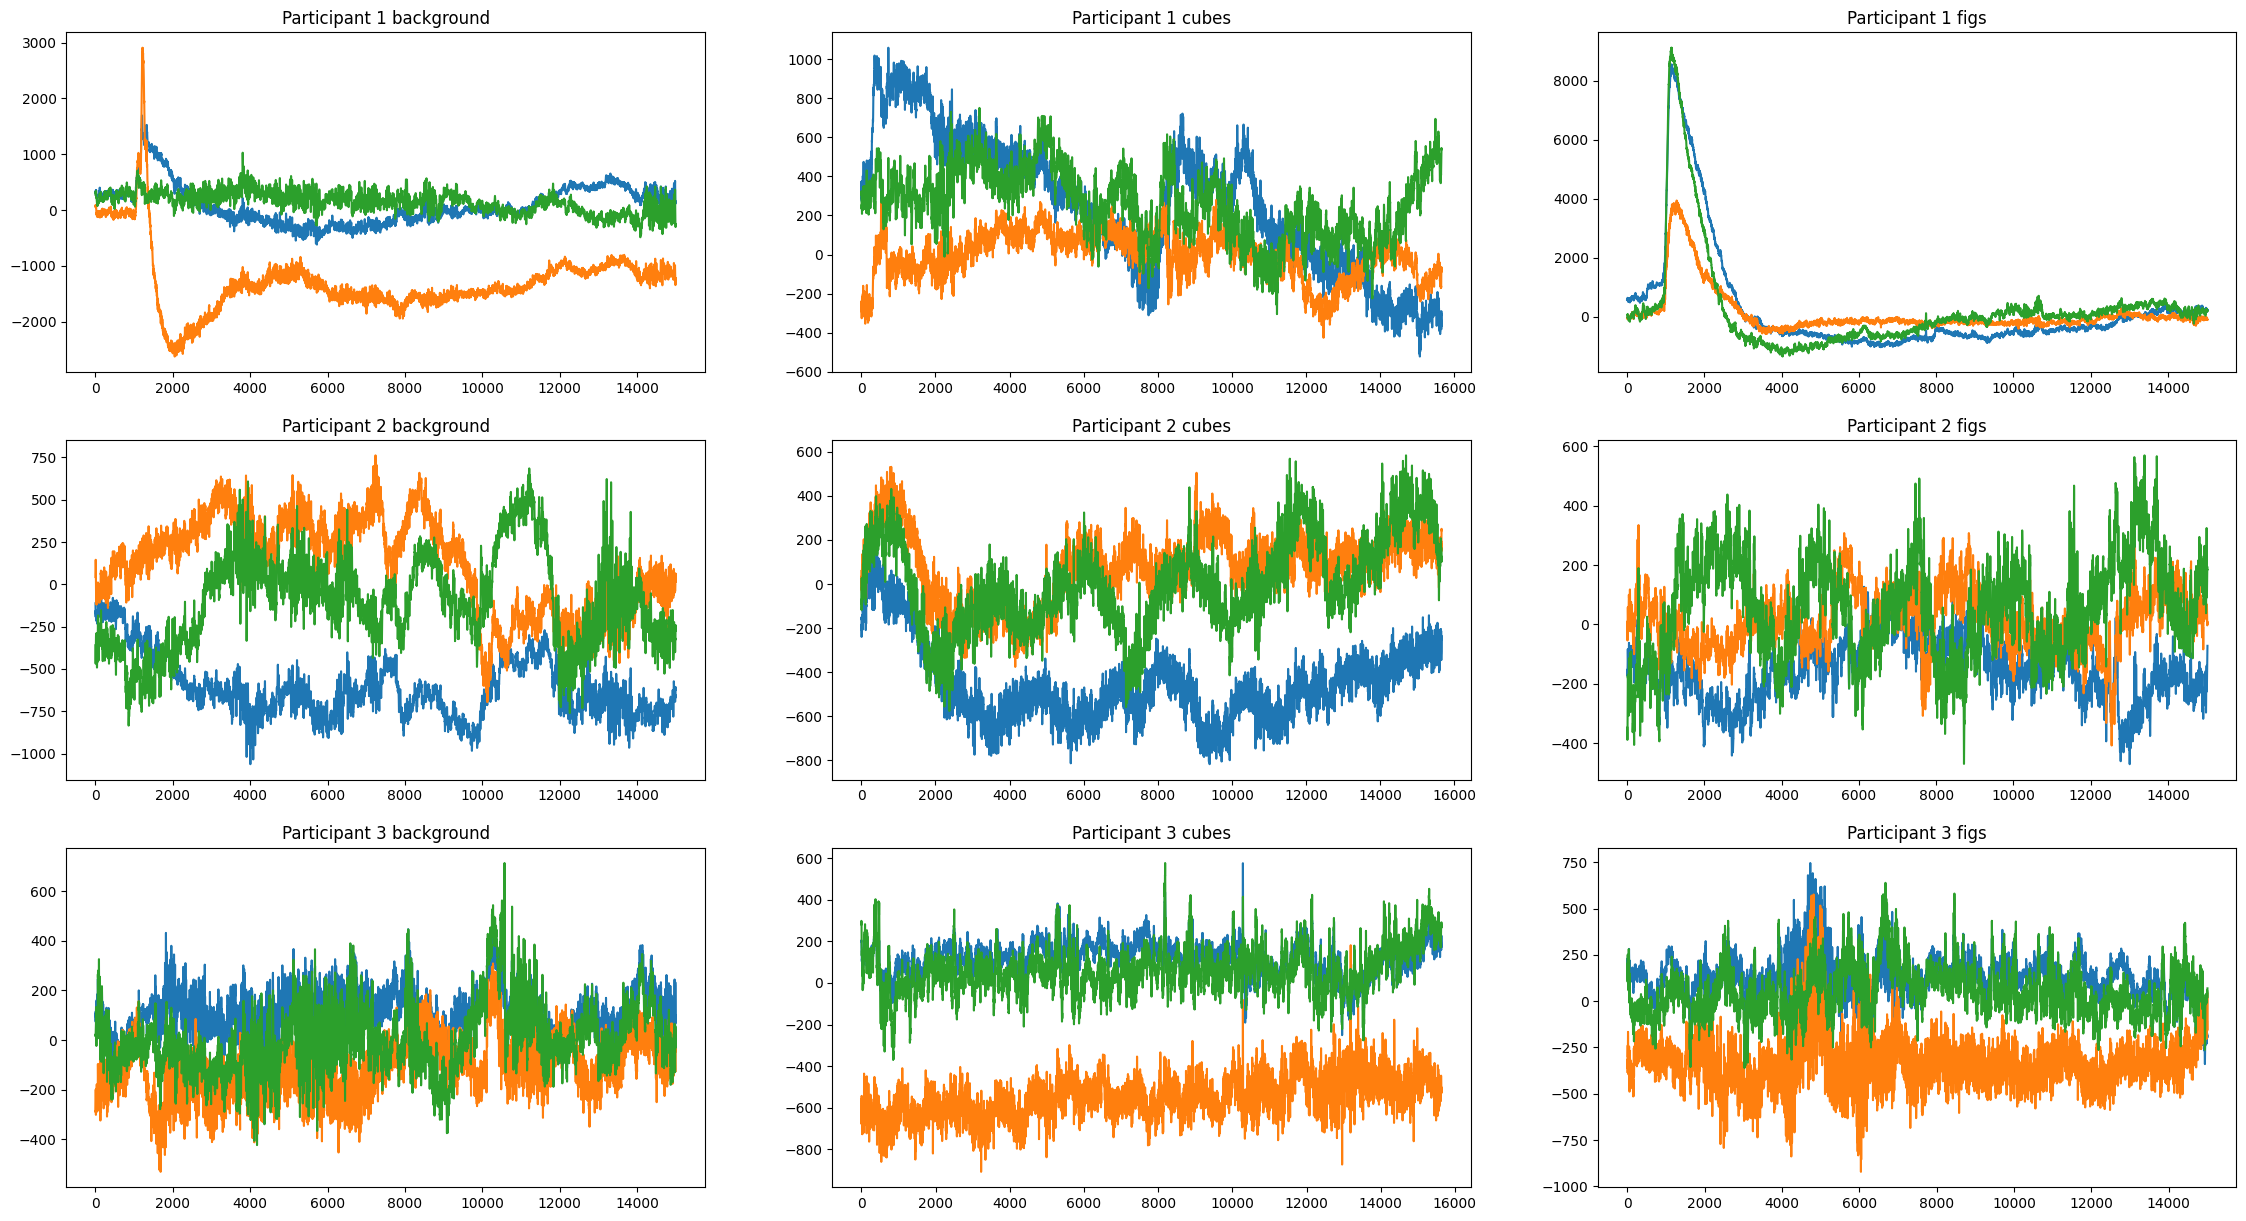

In [17]:
# fig, ax = plt.subplots(3, 3, figsize=(28, 15))

# for i, data_dict in enumerate([background, cubes, figs]):
#     for j, participant in enumerate(["Participant 1", "Participant 2", "Participant 3"]):
#         ax[j, i].set_title(f"{participant} {names[i]}")
#         ax[j, i].plot(data_dict[participant][:, :3])


# To try:
## 1.Fourier spectrograms
## 2. Simple lstm
## 3. Transformers like VIT?